In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from scipy import interpolate
import glob
import os
import matplotlib.pyplot as plt
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

yeart='2012'
montht='0[6-8]'

ROOT='/home5/pharos/REFERENCE_DATA/OCEAN_REP/CORA/CORA5.1/data/'
path=glob.glob(os.path.join(ROOT+yeart+'/*'+yeart+montht+'15_dat_TEMP.nc'))
path.sort()
DAT=xr.open_mfdataset(path,decode_times=False)
DAT=DAT.where((DAT.LATITUDE>=22)&(DAT.LATITUDE<=45)&(DAT.LONGITUDE>=123)&(DAT.LONGITUDE<=170),drop=True)
print len(DAT.N_PROF.values),'profiles'

28181 profiles


In [2]:
#REDUCE TO QC=1
mask = (np.abs(DAT['TEMP']) != np.nan) & (DAT['TEMP_QC'] == 1.)
DAT.coords['mask'] = (('N_PROF', 'N_LEVELS'), mask)
DAT = DAT.where(DAT.mask, drop=True)
DAT = DAT.drop('mask')

#AT LEAST 10 POINTS ON PROFILE WITH MIN DEPTH =< 5m & MAX DEPHT >= 500m
H = DAT['DEPH'].where(DAT['TEMP'].notnull()).max(dim='N_LEVELS')
G = DAT['DEPH'].where(DAT['TEMP'].notnull()).min(dim='N_LEVELS')
DAT = DAT.where((H>=1000)&(G<=5),drop=True)
N = DAT['TEMP'].notnull().sum('N_LEVELS')
DAT = DAT.where(N>=10,drop=True) 

print len(DAT.N_PROF.values),'profiles'

7089 profiles


In [3]:
#REDUCE DIMENSIONS
DAT['A']=DAT['REFERENCE_DATE_TIME'].min(dim='N_LEVELS')
DAT['B']=DAT['DATA_TYPE'].min(dim='N_LEVELS')
DAT['C']=DAT['PLATFORM_NUMBER'].min(dim='N_LEVELS')
DAT['D']=DAT['WMO_INST_TYPE'].min(dim='N_LEVELS')
DAT['E']=DAT['DC_REFERENCE'].min(dim='N_LEVELS')
DAT['F']=DAT['JULD'].min(dim='N_LEVELS')
DAT['G']=DAT['LATITUDE'].min(dim='N_LEVELS')
DAT['H']=DAT['LONGITUDE'].min(dim='N_LEVELS')
DAT['I']=DAT['TEMP_PROC'].min(dim='N_LEVELS')
DAT=DAT.drop(['REFERENCE_DATE_TIME','DATA_TYPE','PLATFORM_NUMBER','WMO_INST_TYPE','DC_REFERENCE',
             'JULD','LATITUDE','LONGITUDE','TEMP_PROC'])
DAT=DAT.rename({'A':'REFERENCE_DATE_TIME','B':'DATA_TYPE','C':'PLATFORM_NUMBER',
                'D':'WMO_INST_TYPE','E':'DC_REFERENCE','F':'JULD','G':'LATITUDE',
                'H':'LONGITUDE','I':'TEMP_PROC'})

In [21]:
DAT.TEMP

<xarray.DataArray 'TEMP' (N_PROF: 7089, N_LEVELS: 152)>
dask.array<shape=(7089, 152), dtype=float32, chunksize=(2220, 152)>
Dimensions without coordinates: N_PROF, N_LEVELS
Attributes:
    long_name:      Temperature (T90) (interpolated on Z_levels)
    units:          degree_Celsius
    standard_name:  sea_water_temperature
    valid_min:      -3.0
    valid_max:      40.0

In [65]:
#INTERPOLATION
#first create the interpolation model between N_LEVELS and DEPH
xx=DAT.DEPH.min(dim='N_PROF').values
yy=range(len(DAT.N_LEVELS))
ft=interpolate.interp1d(xx,yy,bounds_error=False,fill_value='extrapolate')
#now generate the new levels to interpolate on (0m to 500m)
new_depth=np.arange(0,1000,5)
iy=ft(new_depth)
#pre-interpolate NaN values on original depth values
filledT=DAT.TEMP.interpolate_na(dim='N_LEVELS')
#Duplicate 1st value (at 5m or below) to surface
filledT.load()
filledT[:,0:3]=filledT[:,0:3].bfill(dim='N_LEVELS')    
#xarray interpolate profiles
TEMPi=filledT.interp(N_LEVELS=iy)
TEMPi.load()
TEMPi[:,0:3]=TEMPi[:,0:3].bfill(dim='N_LEVELS')  
    
#create new dataset
new_ds=xr.Dataset({'temp':(['N_PROF','DEPTH'],TEMPi.values),
                   'latitude':(['N_PROF'],DAT.LATITUDE.values),
                   'longitude':(['N_PROF'],DAT.LONGITUDE.values),
                   'juld':(['N_PROF'],DAT.JULD.values)},
                  coords={'DEPTH':new_depth})        
print new_ds

<xarray.Dataset>
Dimensions:    (DEPTH: 200, N_PROF: 75764)
Coordinates:
  * DEPTH      (DEPTH) int64 0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 ...
Dimensions without coordinates: N_PROF
Data variables:
    latitude   (N_PROF) float64 41.67 44.0 41.92 41.0 40.17 29.95 34.0 33.33 ...
    longitude  (N_PROF) float64 144.0 155.0 147.8 165.0 165.0 132.9 137.0 ...
    temp       (N_PROF, DEPTH) float64 9.158 9.158 8.838 8.517 8.196 8.012 ...
    juld       (N_PROF) float64 1.839e+04 1.839e+04 1.839e+04 1.839e+04 ...


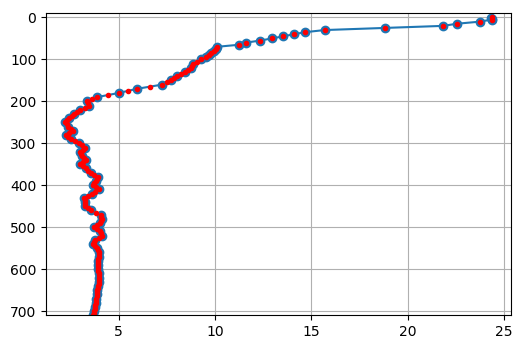

In [69]:
%matplotlib inline
idx=10001
plt.figure(dpi=100)
plt.plot(DAT.TEMP[idx,:],DAT.DEPH[idx,:],'-o')
plt.plot(new_ds.temp[idx,:],new_ds.DEPTH,'r.')
plt.ylim(-10,710)
plt.xlim(new_ds.temp[idx,:].min()-1,new_ds.temp[idx,:].max()+1)
plt.gca().invert_yaxis()
plt.grid()
plt.show()

In [70]:
# From this new dataset, create a more uniform subset to train PCM
# 10 random profiles per 1/2° x 1/2° grid cell

gx=np.arange(123,170,0.5)
gy=np.arange(22,45,0.5)
sub_temp=np.empty([0,len(new_depth)])
sub_lat=np.empty([0])
sub_lon=np.empty([0])
sub_jul=np.empty([0])

for i in gx:
    for j in gy:
        sub_ds=new_ds.where((new_ds.longitude>=i)&(new_ds.longitude<i+0.5)&(new_ds.latitude>=j)&
                           (new_ds.latitude<j+0.5),drop=True)
        if(len(sub_ds.N_PROF)>=10):
            #RANDOM 5
            sel=np.random.choice(range(len(sub_ds.N_PROF)),10,False)
            sub_temp=np.vstack((sub_temp,sub_ds.temp[sel,:].values))
            sub_lat=np.append(sub_lat,sub_ds.latitude[sel].values)
            sub_lon=np.append(sub_lon,sub_ds.longitude[sel].values)           
            sub_jul=np.append(sub_jul,sub_ds.juld[sel].values)  
        else:
            #ALL PROFILES
            sel=sub_ds.N_PROF.values
            sub_temp=np.vstack((sub_temp,sub_ds.temp[sel,:].values))
            sub_lat=np.append(sub_lat,sub_ds.latitude[sel].values)
            sub_lon=np.append(sub_lon,sub_ds.longitude[sel].values)           
            sub_jul=np.append(sub_jul,sub_ds.juld[sel].values)  
            
#new dataset
train_ds=xr.Dataset({'temp':(['N_PROF','DEPTH'],sub_temp),
                   'latitude':(['N_PROF'],sub_lat),
                   'longitude':(['N_PROF'],sub_lon),
                   'juld':(['N_PROF'],sub_jul)},
                  coords={'DEPTH':new_depth})        
print train_ds
        

<xarray.Dataset>
Dimensions:    (DEPTH: 200, N_PROF: 29468)
Coordinates:
  * DEPTH      (DEPTH) int64 0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 ...
Dimensions without coordinates: N_PROF
Data variables:
    latitude   (N_PROF) float64 22.18 22.46 22.18 22.18 22.46 22.48 22.22 ...
    longitude  (N_PROF) float64 123.2 123.1 123.2 123.2 123.1 123.4 123.1 ...
    temp       (N_PROF, DEPTH) float64 29.82 29.82 29.82 29.83 29.83 29.83 ...
    juld       (N_PROF) float64 2.357e+04 2.39e+04 2.357e+04 2.357e+04 ...


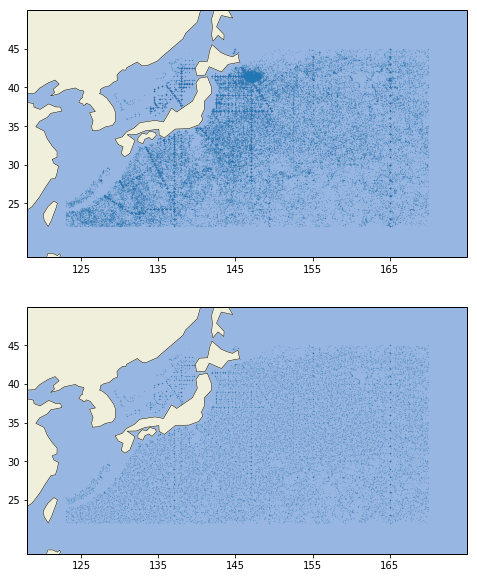

In [74]:
fig = plt.figure(figsize=(15,10))
mproj=ccrs.PlateCarree()

ax = fig.add_subplot(2, 1, 1, projection=mproj)
ax.set_extent([118, 175, 18, 50], crs=mproj)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.set_xticks(range(125,175,10), crs=mproj)
ax.set_yticks(range(25,50,5), crs=mproj)
ax.plot(new_ds.longitude,new_ds.latitude,'.',markersize=0.1)

az = fig.add_subplot(2, 1, 2, projection=mproj)
az.set_extent([118, 175, 18, 50], crs=mproj)
az.add_feature(cfeature.OCEAN)
az.add_feature(cfeature.LAND)
az.add_feature(cfeature.COASTLINE, linewidth=0.5)
az.set_xticks(range(125,175,10), crs=mproj)
az.set_yticks(range(25,50,5), crs=mproj)
az.plot(train_ds.longitude,train_ds.latitude,'.',markersize=0.1)

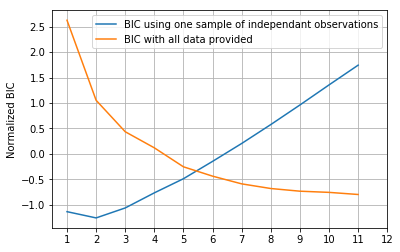

In [85]:
from pyxpcm import pcm

#BIC SIMULATION TO DECIDE HOW MANY CLUSTERS WE USE
kmax = 12
BIC = np.zeros((kmax-1))
BICr = np.zeros((kmax-1))
#Number of independant points : Surface of the quadrangle / surface of a circle r=150km (argo corelation radius)
Sg=(6370**2)*(79-35)*(np.pi/180)*(np.sin(45)-np.sin(28))
Cg=2*np.pi*(150**2)
n=int(np.round(Sg/Cg))

for k in range(1,kmax):
    m = pcm(K=k, feature_axis=np.arange(0,1000,5), feature_name='temperature')
    A=m.fit(train_ds, feature={'temperature': 'temp'})
    Xn=m.preprocessing(train_ds,feature={'temperature':'temp'})
    llih=m._classifier.score(Xn)
    BICr[k-1]=m._classifier.bic(Xn)
    #Dimension de la decomposition verticale des profiles (EOF)
    D = Xn.shape[1]
    Nf = (k+1)-1 + (k+1)*D + (k+1)*D*(D+1)/2      
    BIC[k-1] = -2*n*llih + Nf*np.log(n) #      
    
plt.figure()
plt.plot(np.arange(kmax-1)+1,(BIC-np.mean(BIC))/np.std(BIC), label='BIC using one sample of independant observations')
plt.plot(np.arange(kmax-1)+1,(BICr-np.mean(BICr))/np.std(BICr), label='BIC with all data provided')
plt.ylabel('Normalized BIC')
plt.xticks(np.arange(kmax)+1)
plt.grid()
plt.legend()    

In [88]:
from pyxpcm import pcm
#SO WE CHOOSE N CLUSTERS TO CLASSIFY ALL PROFILES
Knum=2
m = pcm(K=Knum, feature_axis=np.arange(0,1000,5), feature_name='temperature')
m.fit(train_ds, feature={'temperature': 'temp'})
LABELS=m.predict(new_ds, feature={'temperature': 'temp'})
POSTS=m.predict_proba(new_ds, feature={'temperature': 'temp'})

ValueError: Expected the input data X have 13 features, but got 14 features

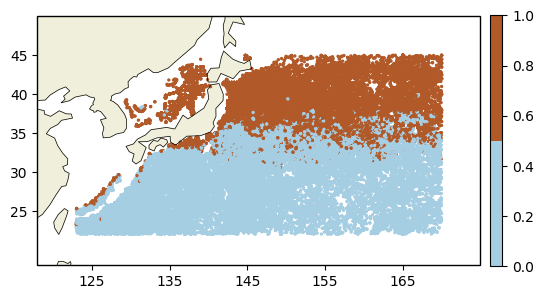

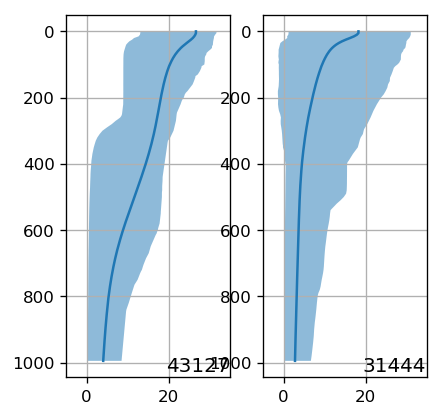

In [84]:
%matplotlib inline
#PLOT CLUSTERS
ccm = cm.get_cmap('Paired', Knum)
fig = plt.figure(dpi=100)
mproj=ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=mproj)
ax.set_extent([118, 175, 18, 50], crs=mproj)
#ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.set_xticks(range(125,175,10), crs=mproj)
ax.set_yticks(range(25,50,5), crs=mproj)
idp=(POSTS.max(dim='N_CLASS')>0.95)
sc=ax.scatter(new_ds.longitude[idp],new_ds.latitude[idp],s=2,alpha=1,c=LABELS[idp],cmap=ccm)
plt.colorbar(sc, fraction=0.027, pad=0.02)

plt.figure(dpi=120)
for i in range(Knum):
    plt.subplot(np.floor((Knum-1)/3)+1,3,i+1)
    if(len(new_ds.temp.where((LABELS==i),drop=True).N_PROF)>0):
        plt.plot(new_ds.temp.where((LABELS==i)&(POSTS.max(dim='N_CLASS')>0.95),drop=True).mean(dim='N_PROF').values,new_depth)    
        minv=new_ds.temp.where((LABELS==i)&(POSTS.max(dim='N_CLASS')>0.95),drop=True).min(dim='N_PROF').values
        maxv=new_ds.temp.where((LABELS==i)&(POSTS.max(dim='N_CLASS')>0.95),drop=True).max(dim='N_PROF').values
        plt.fill_betweenx(new_depth,minv,maxv,alpha=0.5)    
        plt.xlim(-5,35)
        plt.gca().invert_yaxis()
        plt.grid()
        plt.title(str(len(new_ds.temp.where((LABELS==i)&(POSTS.max(dim='N_CLASS')>0.95),drop=True).N_PROF.values)),x=0.8,y=-0.01)
        
plt.show()        